## Conversion Rate
We have data about users who hit our site: whether they converted or not as well as some of
their characteristics such as their country, the marketing channel, their age, whether they are
repeat users and the number of pages visited during that session (as a proxy for site
activity/time spent on site).
Your project is to:
Predict conversion rate
Come up with recommendations for the product team and the marketing team to
improve conversion rate

    country: user country based on IP address
    age: self-reported age
    new_user: whether the account was created during this session
    source: marketing channel
        ads: clicking on an ad
        seo: clicking on a search result
        direct: directly typing the URL on browser
    total_page_visited: proxy for time spent on site and engagement
    converted: whether the user bought anything during the session

In [46]:
pwd

'/home/jovyan/DS challenges'

In [31]:
import pandas as pd
import pyrsm as rsm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.inspection import permutation_importance, plot_partial_dependence
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report

import warnings
warnings.simplefilter('ignore')

## Load data

In [2]:
df = pd.read_csv("Data/conversion_project.csv")

In [3]:
#Backing up unchanged data under a different name
data = df

In [4]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
#Check data type
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

No plot for country (type object)
No plot for source (type object)


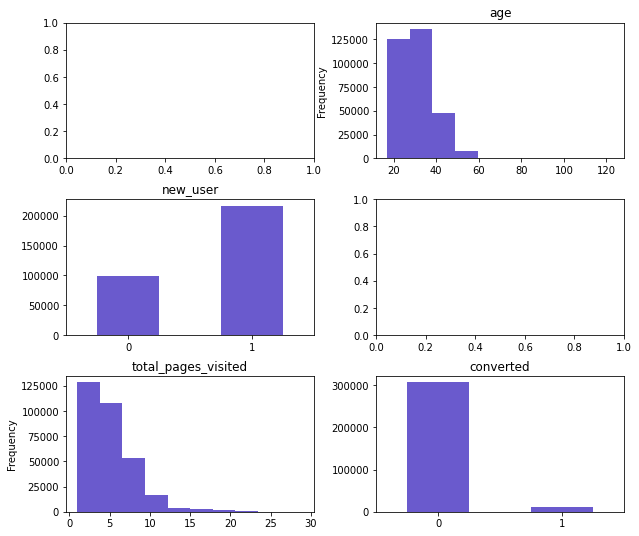

In [6]:
#Check variable distribution
rsm.distr_plot(df)

In [7]:
#Check for missing values: there is none
df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

## Exploratory Data Analysis

### Country
Conversion rate is highest in Germany, followed by UK and the US. One warning sign is that it is particularly low in China. I would suggest looking into the Chinese version of the website/app, to see if the translation is particularly bad, or that the Chinese version alone is buggy

In [8]:
df.groupby('country')['converted'].mean().sort_values(ascending=False)

country
Germany    0.062500
UK         0.052632
US         0.037801
China      0.001332
Name: converted, dtype: float64

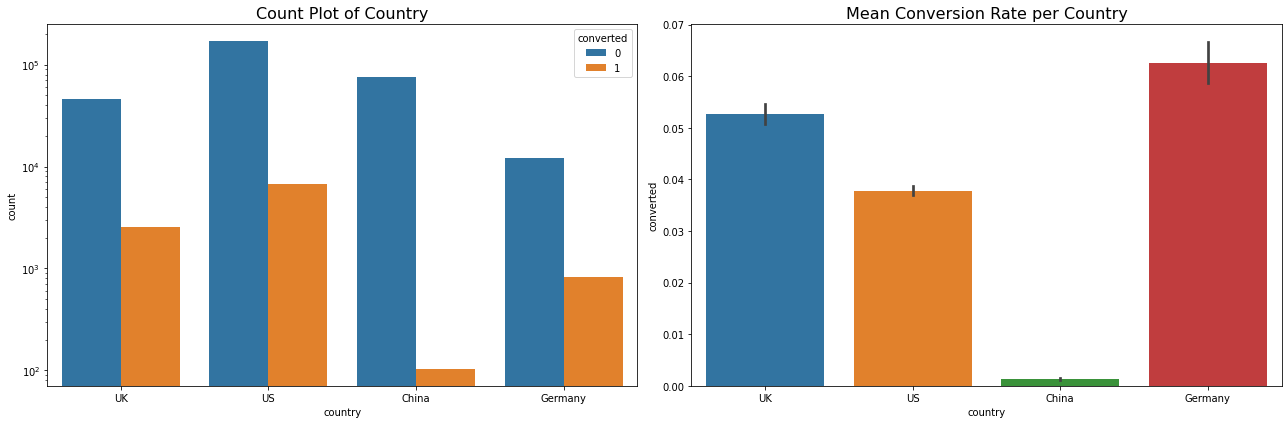

In [9]:
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

### User type
New users are much less likely to convert, which makes sense because 
1. Experienced users, by definition, show more engagement, which typically leads to higher possibility of conversion 
2. New users may indicate less demand

In [11]:
df.groupby('new_user')['converted'].mean().sort_values(ascending=False)

new_user
0    0.072002
1    0.014021
Name: converted, dtype: float64

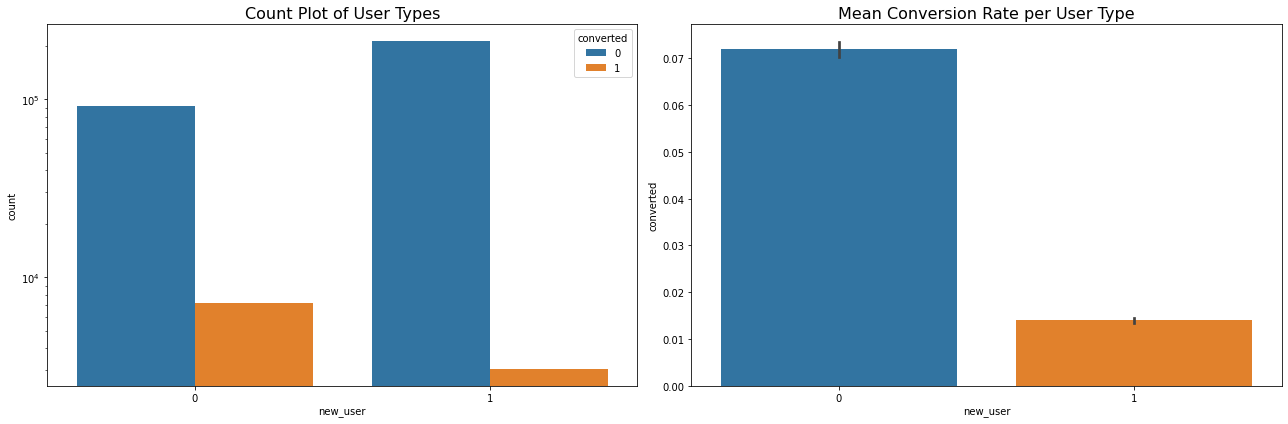

In [12]:
grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

### Sources
Ads leads to the highest likelihood of conversion, followed by search engine and direct link. I would suggest to the company to pivot more of their marketing budget towards deploy more ads

In [11]:
df.groupby('source')['converted'].mean().sort_values(ascending=False)

source
Ads       0.034483
Seo       0.032895
Direct    0.028169
Name: converted, dtype: float64

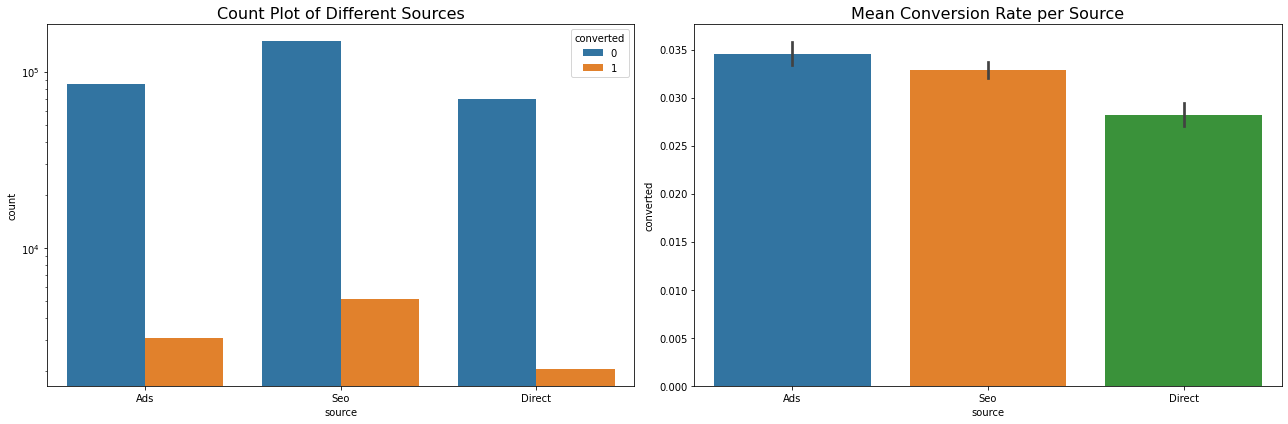

In [14]:
grouped = data[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

### Age
1. Outliers: There are two outliers in age: 111, 123. Since age is self-reported, it is likely that these were mistakes. To correctly visualize the distribution of age, it is crucial to get rid of the outliers first.

2. Advice: After that, it is apparent that the general trend is that, the older the users are, the less likely they are to convert. An actionable advice here could be to try to focus on recruiting younger users.

3. Caveat: One caveat, as shown in the count plot, is that we don't have as many samples from older users (age > 50), so how representative our findings are for older users may be questionable due to having a wide confidence interval.

<AxesSubplot:xlabel='age'>

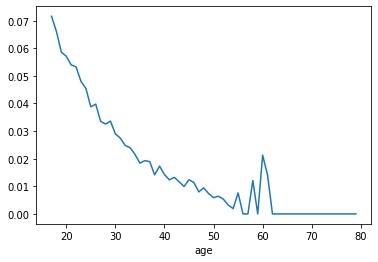

In [10]:
df.query("`age` < 100").groupby('age')['converted'].mean().plot()

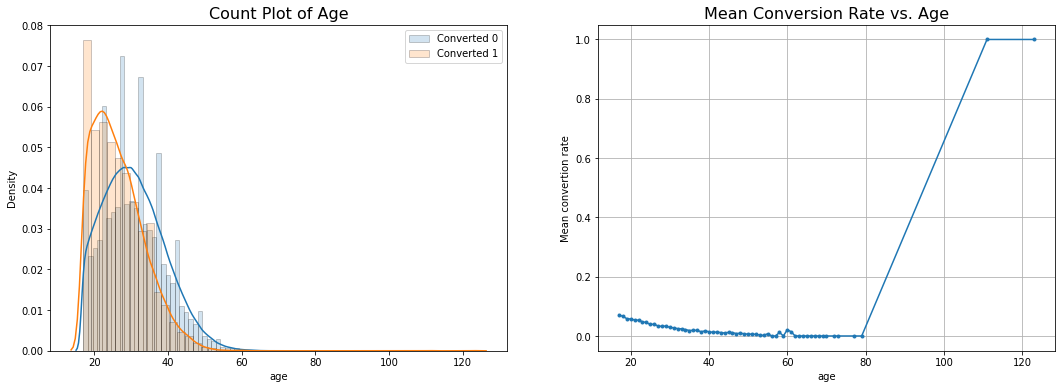

In [15]:
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

### Total pages visited
Conversion rate starts to increase at 5 total pages visited, and peaks at 14. An advice for the company is to incentivize users to look at more pages, such as creating a recommendation system, before they reach a total of 14 pages. After that the conversion rate starts going down, so it may make sense to ask the user whether they would like to convert around the same time.

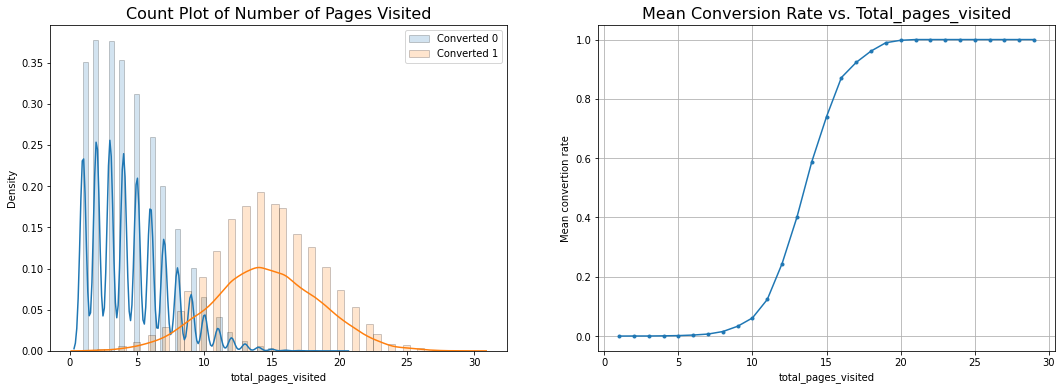

In [16]:
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Number of Pages Visited', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

## Logistic Regression with Statsmodel
After exploring variables, I decided to run a simple, linear model to verify my findings through simple group by and plotting graphs, and to compare among variables which ones are more influential in predicting conversion. 

The odds ratio plot largely verified my findings in the last section. In addition, it also gave us a list of variables ranked by their importances.

In [17]:
df["source"] = df["source"].astype("category").cat.reorder_categories(["Direct", "Seo","Ads"])
df["country"] = df["country"].astype("category").cat.reorder_categories(["US", "China","UK","Germany"])

In [18]:
lr = smf.glm(
    formula="converted ~ country + age + new_user + source + total_pages_visited",
    family=Binomial(link=logit()),
    data=df,
).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:               316200
Model:                            GLM   Df Residuals:                   316191
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12853.
Date:                Tue, 18 May 2021   Deviance:                       25705.
Time:                        08:48:11   Pearson chi2:                 2.54e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -7.3056      0.096    -75.834      0.000      -7.494      -7.117
country[T.China]       -3.2462      0.117    -27.847      0.000      -3.475      -3.018
country[T.UK]           0.3643      0.041      8.879      0.000       0.284       0.445
country[T.Germany]      0.5728      0.068      8.404      0.000       0.439       0.706
source[T.Seo]           0.1625      0.044      3.676      0.000       0.076       0.249
source[T.Ads]           0.1867      0.049      3.833      0.000       0.091       0.282
age                    -0.0731      0.002    -30.858      0.000      -0.078      -0.068
new_user               -1.7395      0.036    -48.906      0.000      -1.809      -1.670
total_pages_visited     0.7582      0.006    122.134      0.000       0.746       0.770
=======================================================================================
"""

In [19]:
rsm.or_ci(lr)

,index,OR,OR%,2.5%,97.5%,p.values,
1,country[T.China],0.039,-96.1%,0.031,0.049,< .001,***
2,country[T.UK],1.440,44.0%,1.328,1.560,< .001,***
3,country[T.Germany],1.773,77.3%,1.551,2.027,< .001,***
4,source[T.Seo],1.176,17.6%,1.079,1.283,< .001,***
5,source[T.Ads],1.205,20.5%,1.096,1.326,< .001,***
6,age,0.930,-7.0%,0.925,0.934,< .001,***
7,new_user,0.176,-82.4%,0.164,0.188,< .001,***
8,total_pages_visited,2.134,113.4%,2.109,2.161,< .001,***


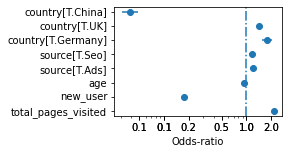

In [20]:
fig = rsm.or_plot(lr, figsize=(3,2))

In [21]:
rsm.or_ci(lr, importance=True, data=df).sort_values(
    "importance", ascending=False
)

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance,mean,std,min,max
1,country[T.China],0.039,-96.1%,0.031,0.049,< .001,***,True,25.692,0.242,0.428,0.0,1.0
7,new_user,0.176,-82.4%,0.164,0.188,< .001,***,False,5.694,0.685,0.464,0.0,1.0
8,total_pages_visited,2.134,113.4%,2.109,2.161,< .001,***,False,2.134,4.873,3.341,1.0,29.0
3,country[T.Germany],1.773,77.3%,1.551,2.027,< .001,***,True,1.773,0.041,0.199,0.0,1.0
2,country[T.UK],1.440,44.0%,1.328,1.560,< .001,***,True,1.440,0.153,0.360,0.0,1.0
5,source[T.Ads],1.205,20.5%,1.096,1.326,< .001,***,True,1.205,0.281,0.449,0.0,1.0
4,source[T.Seo],1.176,17.6%,1.079,1.283,< .001,***,True,1.176,0.490,0.500,0.0,1.0
6,age,0.930,-7.0%,0.925,0.934,< .001,***,False,1.076,30.570,8.272,17.0,123.0


## XGBoost model
To find potential non-linear interactions not captured by logistic regression.\
Also a framework to compare ranking of variable importances.

Total pages visited has become a much more important feature as a result of the XGBoost model, signaling potential non-linear effects associated with it, which we will inspect using partial dependence plot.

In [17]:
df = pd.get_dummies(df)

In [18]:
#cross validation
X = df.copy()
y = X.pop("converted")

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [20]:
clf = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=300,
    objective="binary:logistic",
    use_label_encoder=False,
    # early_stopping_rounds=10,
    eval_metric="auc",
    random_state=1234,
    n_jobs=6
).fit(X_train, y_train, verbose=True)

# predict for the entire dataset
df["y_xgb"] = clf.predict_proba(X)[:, 1]

# XGBoost with cross-validation and grid search
# clf = xgb.XGBClassifier()
# param_grid = {
#     "max_depth": list(range(1, 3)),
#     "n_estimators": list(range(100, 301, 100)),
# }
# scoring = {"AUC": "roc_auc"}

# clf_cv = GridSearchCV(
#     clf, param_grid, scoring=scoring, cv=5, n_jobs=6, refit="AUC", verbose=5
# ).fit(X_train, y_train)

# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # predict for the entire dataset
# eval_dat["y_xgb_cv"] = clf_cv.predict_proba(X)[:, 1]

# # performance evaluations
# models = list(eval_dat.columns.values[3:])
# models


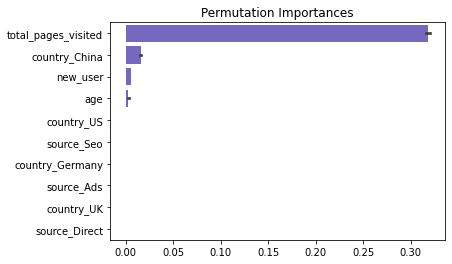

In [21]:
def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig
fig = importance(clf, X_test, y_test, X.columns)

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


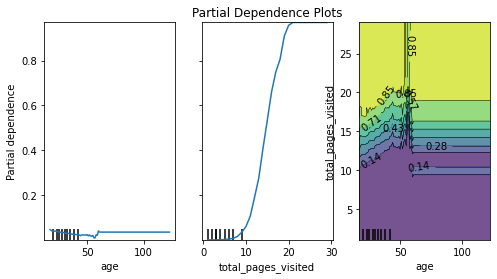

In [34]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Partial Dependence Plots")
fig = plot_partial_dependence(
    clf, X, ["age", "total_pages_visited", ("age", "total_pages_visited")], ax=ax
)

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


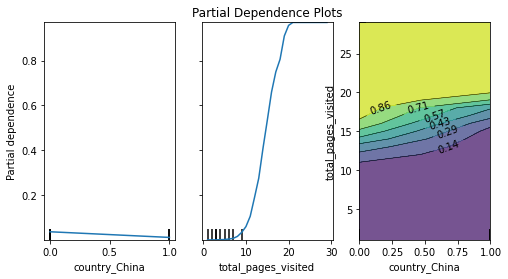

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Partial Dependence Plots")
fig = plot_partial_dependence(
    clf, X, ["country_China", "total_pages_visited", ("country_China", "total_pages_visited")], ax=ax
)

### Model Evaluation
1. AUC: 0.98 on training and testing data, which is pretty good! And no overfitting!
2. f1-score: is a bit low because of low recall. Could adjust the threshold (0.4 right now, can try lowering it further) to increase recall at cost of lowering precision.
3. gains plot: we can reach very close to 100% of the converts by targeting the top 20% of customers based on XGB predictions. Pretty good!
4. lift plot: by targeting the top 20%, we can achieve 5-10 times as much converts as there were no segmentation

In [29]:
pred = clf.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train.values, pred[:,1])
auc_rf = auc(fpr, tpr)
auc_rf

0.9866141367168326

In [35]:
pred = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test.values, pred[:,1])
auc_rf = auc(fpr, tpr)
auc_rf

0.9858487901732781

In [39]:
print(classification_report(y_true=y_test, y_pred = pred[:,1] > 0.4))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     61217
           1       0.81      0.73      0.77      2023

    accuracy                           0.99     63240
   macro avg       0.90      0.86      0.88     63240
weighted avg       0.99      0.99      0.99     63240



<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

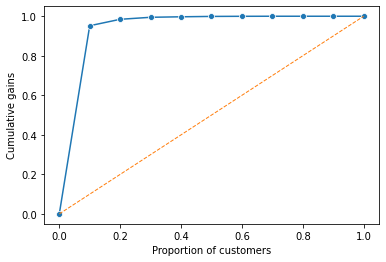

In [43]:
rsm.gains_plot(df=df, lev=1, pred='y_xgb', rvar='converted')

<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative lift'>

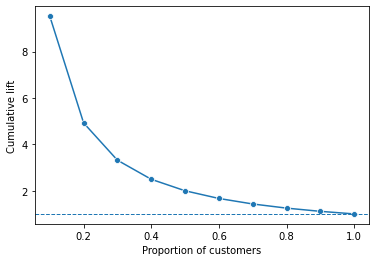

In [45]:
rsm.lift_plot(df=df, lev=1, pred='y_xgb', rvar='converted')